In [1]:
%load_ext autoreload
%autoreload 2
import emcee
import numpy as np
import sys
sys.path.append('/data1/yujiehe/anisotropy-flamingo')
import tools.constants as const
import tools.clusterfit as cf
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=68.1, Om0=0.306, Ob0=0.0486)

C = 299792.458                  # the speed of light in km/s


def log_likelihood(theta, X, Y, z_obs, phi_lc, theta_lc, yname, xname):
    """
    X, Y, z_obs, phi_lc, theta_lc, are from the data
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
       return -np.inf 
    
    ubf, vlon, vlat, logA, B, sigma, = theta

    # Set the scaling relation to know the pivot point
    scaling_relation = f'{yname}-{xname}'

    # Calculate the redshift
    angle = cf.angular_separation(phi_lc, theta_lc, vlon, vlat) * np.pi/180
    
    # Correct the bulk flow accordingly: z_bf = z_obs + ubf * (1 + z_bf) * np.cos(angle) / C
    z_bf = (z_obs + ubf * np.cos(angle) / C) / (1 - ubf * np.cos(angle) / C) # Non-relativistic correction

    # The relativistic correction
    # u_c_correct=((1+z_obs)**2-1)/((1+z_obs)**2+1) + (1+z_obs)*ubf*np.cos(angle)/C
    # z_bf=np.sqrt((1+u_c_correct)/(1-u_c_correct))-1

    # Calculate the Luminosity distance
    if yname == 'LX':
        # DL_zobs = cc.DL(z_obs, H0=68.1, Om=0.306, Ol=0.694)
        # DL_zbf = cc.DL(z_bf, H0=68.1, Om=0.306, Ol=0.694)
        DL_zobs = cosmo.luminosity_distance(z_obs).value
        DL_zbf = cosmo.luminosity_distance(z_bf).value
        Y_bf = Y*(DL_zbf)**2/(DL_zobs)**2
    elif yname == 'YSZ':
        DA_zobs = cosmo.angular_diameter_distance(z_obs).value
        DA_zbf = cosmo.angular_diameter_distance(z_bf).value
        Y_bf = Y*(DA_zbf)**2/(DA_zobs)**2
    elif yname == 'M':
        DA_zobs = cosmo.angular_diameter_distance(z_obs).value 
        DA_zbf = cosmo.angular_diameter_distance(z_bf).value 
        Y_bf = Y*(DA_zbf)**(5/2)/(DA_zobs)**(5/2)
        
    # To our fit parameters
    logY_ = cf.logY_(Y_bf, z=z_bf, relation=scaling_relation)
    logX_ = cf.logX_(X, relation=scaling_relation)

    model = B * logX_ + logA
    lnL = -0.5 * np.sum((logY_ - model) ** 2 / (sigma**2) + np.log(sigma**2)) # Kostas' implementation

    return lnL + lp

# set prior
def log_prior(theta):
    # A large flat prior for now
    ubf, vlon, vlat, logA, B, sigma = theta # 6 parameters

    # If in range, p(theta)=1, else p(theta)=0
    if -1<logA<1 and 0.5<B<3.5 and 0.05<sigma<1 \
        and 0<ubf<1000 and -180<vlon<180 and -90<vlat<90:
        return 0.0
    else:
        return -np.inf


In [2]:
import pandas as pd
data = pd.read_csv('../data/samples_in_lightcone0_with_trees_duplicate_excision_outlier_excision.csv')
data

,lc_id,redshift,theta_on_lc,phi_on_lc,M_fof_lc,x_lc,y_lc,z_lc,snap_num,MfofSOAP,...,Y5R500WithoutRecentAGNHeating,Vx,Vy,Vz,GalaxyID,TopLeafID,3DLcore/Ltot,ObservedRedshift,Flux,2DLcore/Ltot
0,12678101,0.049663,68.444418,-146.100556,3.221621e+14,-65.892905,-44.277266,200.964592,76,3.221569e+14,...,13.394281,-138.41480,146.285160,-258.814820,264729502,264729571,0.629913,0.048863,1.930583e-11,0.655002
1,13217952,0.031250,61.242576,66.517408,2.121565e+14,26.197568,60.300376,119.801093,76,2.122057e+14,...,8.353127,136.95007,85.050050,156.950070,758729120,758729192,0.563404,0.031943,3.424318e-11,0.619050
2,11897316,0.016130,-50.768598,-21.506782,9.199489e+13,41.950287,-16.530393,-55.223603,77,9.194666e+13,...,1.736042,-143.69714,-196.297180,-29.697144,735257909,735257982,0.587601,0.016076,1.415207e-11,0.580910
3,12785470,0.019369,28.752838,151.820271,1.019505e+14,-65.416111,35.046019,40.719139,77,1.019797e+14,...,2.198071,-126.92236,256.877560,1.177612,553518674,553518749,0.448886,0.020066,1.010312e-11,0.540358
4,6057316,0.077597,-74.324178,-132.555680,2.872746e+14,-61.330249,-66.799779,-323.142433,75,2.875223e+14,...,12.424476,168.31421,95.214230,99.214230,256178182,256178252,0.538358,0.077076,7.649637e-12,0.485846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,11804705,0.085544,22.449321,158.121013,5.532838e+14,-316.531368,127.109968,140.934807,75,5.530544e+14,...,77.584358,492.35680,242.556760,50.656740,795913407,795913476,0.020071,0.084388,2.813252e-11,0.060460
702,11861703,0.028225,-55.011456,-126.277785,7.538000e+13,-41.823558,-56.982167,-100.989675,76,7.531655e+13,...,2.511428,98.96692,-309.533080,-453.733030,261040288,261040362,0.020155,0.029877,7.749973e-12,0.057530
703,4646616,0.125712,-33.564085,-169.939991,8.079670e+14,-442.983802,-78.588470,-298.507096,74,8.081410e+14,...,140.383773,-671.88740,77.012570,-361.787350,690964560,690964632,0.002155,0.128495,6.101368e-12,0.047056
704,12882763,0.052263,43.009397,-35.045370,1.727982e+14,135.647971,-95.141897,154.556921,76,1.728982e+14,...,10.978919,-296.42468,159.875300,135.375300,583385361,583385430,0.011669,0.051729,5.409843e-12,0.042653


In [3]:
# Load data and set zmax
data  = data[:313]
yname = 'LX'
xname = 'T'
zmax  = 0.08

# Load data
z_obs    = data['ObservedRedshift'].values
X        = data[cf.COLUMNS[xname]].values
Y        = data[cf.COLUMNS[yname]].values
phi_lc   = data['phi_on_lc'].values
theta_lc = data['theta_on_lc'].values

# Select data below some redshift
zmask    = z_obs < zmax
z_obs    = z_obs[zmask]
X        = X[zmask]
Y        = Y[zmask]
phi_lc   = phi_lc[zmask]
theta_lc = theta_lc[zmask]

print(np.sum(zmask)) # Number of clusters left

182


## Use a Scipy solver for initial condition

In [4]:
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
nll = lambda *args: -log_likelihood(*args)
initial = np.array([0, 0, 0, 1, 1, 0.1]) # initial guess
bounds = [(0, 1000), (-180, 180), (-90, 90), (0.1, 1), (0.5, 3.5), (0.05, 1)]

soln = differential_evolution(nll, args=(X, Y, z_obs, phi_lc, theta_lc, yname, xname), 
                bounds=bounds, popsize=10, strategy='rand1bin')
print(soln.x)

[ 4.85342065e+02 -1.31376235e+02  3.09022614e+00  2.04293604e-01
  2.54060470e+00  1.27485835e-01]


/data1/yujiehe/conda-env/halo/lib/python3.11/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


### MCMC with EMCEE

In [5]:
pos0 = soln.x + 1e-2 * np.random.randn(32, 6)
nwalkers, ndim = pos0.shape

# Create a sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, 
                                args=(X, Y, z_obs, phi_lc, theta_lc, yname, xname))

# Run
sampler.run_mcmc(pos0, 10000, progress=True)

100%|██████████| 10000/10000 [05:31<00:00, 30.20it/s]


State([[ 4.06708129e+02 -1.20452407e+02  6.34332633e+00  2.09595987e-01
   2.63582932e+00  1.35974831e-01]
 [ 1.48684972e+02  1.75591066e+02  3.01035081e+01  1.74528294e-01
   2.52149509e+00  1.44988760e-01]
 [ 5.21144886e+02  1.24711315e+02  3.94190985e+01  1.89530035e-01
   2.54153037e+00  1.40390033e-01]
 [ 5.68111727e+02 -1.47557068e+02 -2.69033862e-02  1.90785180e-01
   2.62106584e+00  1.38949242e-01]
 [ 2.10053428e+02 -1.36495745e+02  6.20143915e+01  2.03742690e-01
   2.60291137e+00  1.32947411e-01]
 [ 9.96990327e+01  9.44894047e+01 -4.87915003e+01  1.96071958e-01
   2.49371593e+00  1.35781411e-01]
 [ 1.78121276e+02  1.56981687e+02 -6.80699549e+01  1.88794215e-01
   2.60515654e+00  1.45276659e-01]
 [ 4.75870918e+02 -1.01141742e+02 -2.88318037e+01  2.08184069e-01
   2.56528558e+00  1.35399875e-01]
 [ 5.09831373e+02 -1.19961657e+02 -5.40396869e+00  1.89009557e-01
   2.53009662e+00  1.43138107e-01]
 [ 2.54075172e+02  1.55365672e+02  7.77674394e+01  2.17296182e-01
   2.69837798e+00  

In [6]:
try:
    tau = sampler.get_autocorr_time()
    print(tau)
except emcee.autocorr.AutocorrError:
    print('The chain is too short to get a reliable autocorrelation time.')
    tau = 0

The chain is too short to get a reliable autocorrelation time.


Throw away a few times this number of steps as “burn-in”. And thin by about half the autocorrelation time.

In [41]:
tau = sampler.get_autocorr_time()

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 200;
tau: [177.17103111 303.51023496 166.73173881 119.68538996 116.71169342
 127.77854318]

In [37]:
flat_samples = sampler.get_chain(discard=1000, thin=60, flat=True)
print(flat_samples.shape)

(4800, 6)


Text(0.5, 0.98, 'LX-T with z<0.08')

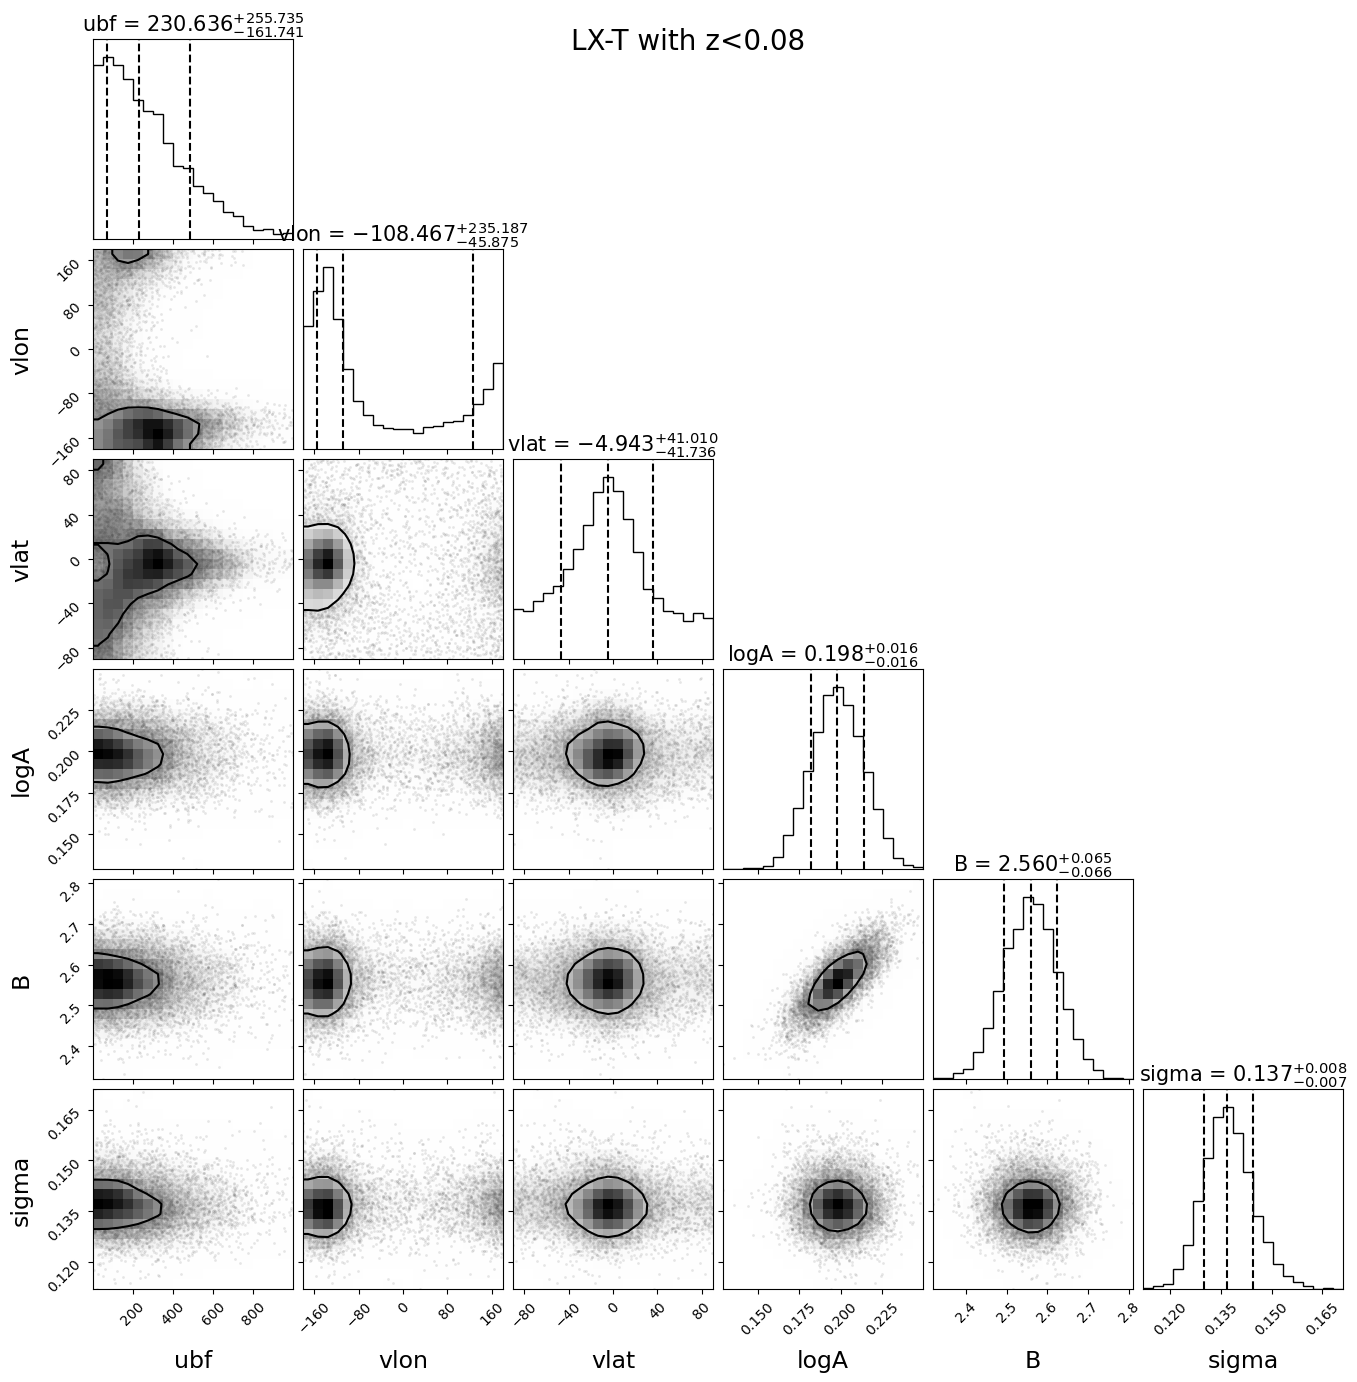

In [8]:
import corner
import matplotlib.pyplot as plt

fig = corner.corner(
    flat_samples, 
    labels=['ubf', 'vlon', 'vlat', 'logA', 'B', 'sigma'],
    quantiles=[0.16, 0.5, 0.84],
    show_titles=True, 
    title_fmt='.3f',
    title_kwargs={"fontsize": 15},
    label_kwargs={"fontsize": 17},
    smooth=1,
    levels=[0.39],
)

# Title
fig.suptitle(f'{yname}-{xname} with z<{zmax}', fontsize=20)

## Interpretation of the results

In [39]:
# The highest probability values and the quantiles for vlon and vlat
vlon_distr = flat_samples[:, 1]
hist, edges = np.histogram(vlon_distr, bins=30, density=True)
peak_vlon = edges[np.argmax(hist)]

# Shift to peak=0 to avoid breaking near the edge
vlon_distr = (vlon_distr - peak_vlon - 180) % 360 - 180 # Despite the shift, keep the range in 180 to 180

# 34th percentile around the peak value
peak_percentile = np.sum(vlon_distr < 0) / len(vlon_distr) * 100
l = np.percentile(vlon_distr, peak_percentile - 34)
u = np.percentile(vlon_distr, peak_percentile + 34)

# Convert back to the original coordinates
lower_vlon = (l + peak_vlon + 180) % 360 - 180
upper_vlon = (u + peak_vlon + 180) % 360 - 180
print(f'vlon: {lower_vlon} ~ {upper_vlon} \nor {peak_vlon} +{u-0} -{0-l}')

vlon: 152.25076306220103 ~ -86.83068355115563 
or -143.98797385729114 +57.1572903061355 -63.76126308050782


In [40]:
# The highest probability values and the quantiles for vlon and vlat
vlat_distr = flat_samples[:, 2]
hist, edges = np.histogram(vlat_distr, bins=30, density=True)
peak_vlat = edges[np.argmax(hist)]

# Shift to peak=0 to avoid breaking near the edge
vlat_distr = (vlat_distr - peak_vlat - 90) % 180 - 90 # Despite the shift, keep the range in -90 to 90

# 34th percentile around the peak value
peak_percentile = np.sum(vlat_distr < 0) / len(vlat_distr) * 100
l = np.percentile(vlat_distr, peak_percentile - 34)
u = np.percentile(vlat_distr, peak_percentile + 34)

# Convert back to the original coordinates
lower_vlat = (l + peak_vlat + 90) % 180 - 90
upper_vlat = (u + peak_vlat + 90) % 180 - 90
print(f'vlat: {lower_vlat} ~ {upper_vlat} \nor {peak_vlat} +{u-0} -{0-l}')

vlat: -48.79774315432709 ~ 33.95042984220714 
or -6.004242169318815 +39.95467201152596 -42.79350098500827


In [11]:
# Most probable direction in 3d distribution
hist3d, edges = np.histogramdd(flat_samples[:,:3], bins=30, range=None, density=None, weights=None)
peak_ubf, peak_vlon, peak_vlat = np.where(hist3d==hist3d.max())
peak_ubf = edges[0][peak_ubf]
peak_vlon = edges[1][peak_vlon]
peak_vlat = edges[2][peak_vlat]
print(peak_ubf, peak_vlon, peak_vlat)

[465.88552851] [-143.98797386] [-18.00050805]


In [16]:
from scipy.stats import gaussian_kde
# Perform KDE
kde = gaussian_kde(flat_samples[:,:3].T)

# Evalute the KDE at a grid of points
x = np.linspace(np.min(flat_samples[:, 0]), np.max(flat_samples[:, 0]), 100)
y = np.linspace(np.min(flat_samples[:, 1]), np.max(flat_samples[:, 1]), 100)
z = np.linspace(np.min(flat_samples[:, 2]), np.max(flat_samples[:, 2]), 100)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
kde_values = kde(positions).reshape(X.shape) # Probability values

# Find the peak of the KDE
peak_index = np.unravel_index(np.argmax(kde_values, axis=None), kde_values.shape)
peak = np.array([x[peak_index[0]], y[peak_index[1]], z[peak_index[2]]])
print(peak)

[110.97179559 -49.10889683  -0.91491725]


In [30]:
# Find the percentile ranges centered around the peak
one_sigma_region = kde_values > np.percentile(np.ravel(kde_values), 80) # 3D 1-sigma
X[one_sigma_region].min(), X[one_sigma_region].max()
Y[one_sigma_region].min(), Y[one_sigma_region].max()

(-179.9765892815174, 179.9095649607453)

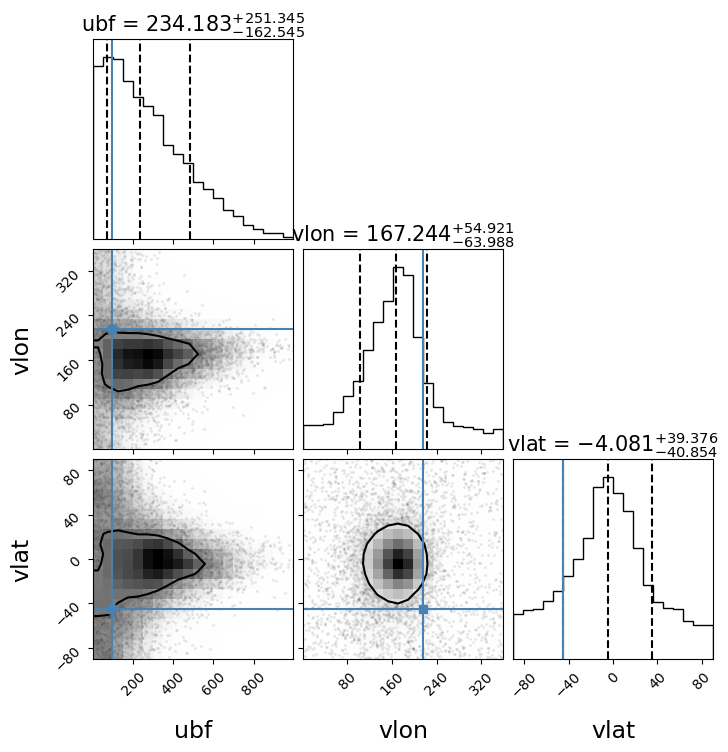

In [ ]:
import corner
import matplotlib.pyplot as plt

plot_samples = flat_samples.copy()
plot_samples[:, 1] = (plot_samples[:, 1] - peak_vlon + 180) % 360

fig = corner.corner(
    plot_samples[:, :3],
    labels=['ubf', 'vlon', 'vlat'],
    quantiles=[0.16, 0.5, 0.84],
    truths=[96.98, -96.67 - peak_vlon + 180, -44.97],
    levels=[0.39],
    show_titles=True, 
    title_fmt='.3f',
    title_kwargs={"fontsize": 15},
    label_kwargs={"fontsize": 17},
    smooth=1
)

# Extract the axes
# axes = np.array(fig.axes).reshape((ndim, ndim))